# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat  PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

$$\Large F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $$

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner
import scipy.optimize as opt

/home/berres2002/miniconda3/envs/fds/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
d1=pd.read_csv('PS1_PS1MD_PSc000098.snana.dat',header=14,sep='\s+',skipfooter=1,engine='python')
d2=pd.read_csv('PS1_PS1MD_PSc000174.snana.dat',header=14,sep='\s+',skipfooter=1,engine='python')

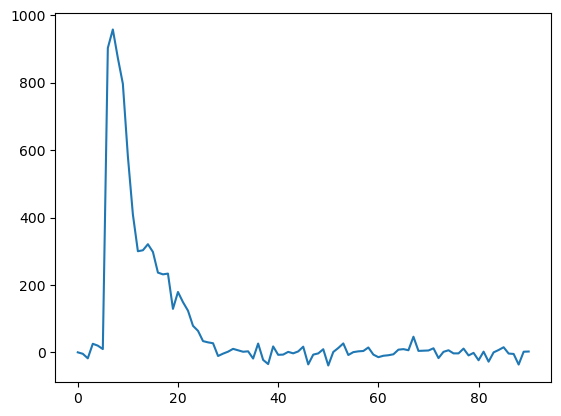

In [22]:
plt.plot(d1.query('FLT == "g"').FLUXCAL);

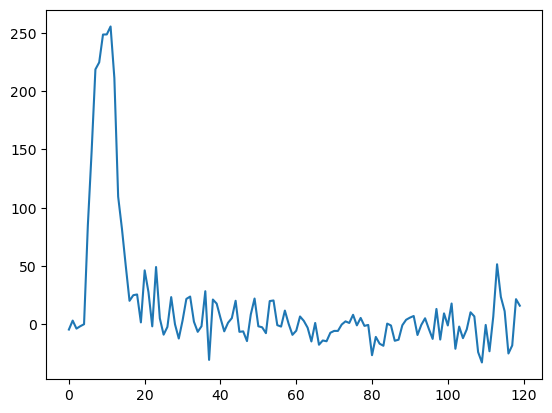

In [20]:
plt.plot(d2.query('FLT == "g"').FLUXCAL);

|Parameter| Description| Prior |
|--------:|-----------:|:------|
|τrise (days) |Rise Time |U(0.01,50)|
|τfall (days) |Decline Time| U(1,300)|
|t0 (MJD) |“Start” Time| U(tmin − 50, tmax + 300)|
|A| Amplitude| U(3σ,100 Fmax)|
|β (flux/day)| Plateau slope| U(−Fmax/150,0)|
|c (flux) |Baseline Flux| U(−3σ,3σ)|
|γ (days) |Plateau duration|(2/3)N(5, 5) + (1/3) N(60, 30) |

She used equation 1, defined here: https://arxiv.org/abs/1905.07422

$$\Large F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $$

In [29]:
d1.columns

Index(['VARLIST:', 'MJD', 'FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG',
       'MAGERR'],
      dtype='object')

In [27]:
def fmod(t,A,b,tr,tf,t0,t1):
    if t < t1:
        ug1= A+b*(t-t0)
        ug2=1+np.exp(-(t-t0)/tr)
        
    elif t >= t1:
        ug1 = (A+b*(t1-t0))*np.exp(-(t-t1)/tf)
        ug2 = 1+np.exp((-t-t0)/tr)
    else:
        ug1=-np.inf
        ug2=np.inf
    return ug1/ug2

In [48]:
np.piecewise()

TypeError: _piecewise_dispatcher() missing 3 required positional arguments: 'x', 'condlist', and 'funclist'

In [46]:
def loss(vl,data):
    og=(data.FLUXCAL.values-fmod(data.MJD,vl[0],vl[1],vl[2],vl[3],vl[4],vl[5]))/(2*data.FLUXCALERR.values)
    return og**2

|Parameter| Description| Prior |
|--------:|-----------:|:------|
|τrise (days) |Rise Time |U(0.01,50)|
|τfall (days) |Decline Time| U(1,300)|
|t0 (MJD) |“Start” Time| U(tmin − 50, tmax + 300)|
|A| Amplitude| U(3σ,100 Fmax)|
|β (flux/day)| Plateau slope| U(−Fmax/150,0)|
|c (flux) |Baseline Flux| U(−3σ,3σ)|
|γ (days) |Plateau duration|(2/3)N(5, 5) + (1/3) N(60, 30) |

In [42]:
ndim=6
nwalkers=20
np.random.seed(10)
starting_guesses = np.zeros((nwalkers, ndim))
# starting_guesses[:, 2] = np.random.uniform(0.01, 1, (nwalkers, 1))
# starting_guesses[:,0] = np.random.uniform((nwalkers,1))
starting_guesses = np.random.uniform(size=(nwalkers,ndim))
starting_guesses;

In [47]:
emcee.EnsembleSampler(nwalkers,ndim,loss,args=[d1]).run_mcmc(starting_guesses, 10)

emcee: Exception while calling your likelihood function:
  params: [0.77132064 0.02075195 0.63364823 0.74880388 0.49850701 0.22479665]
  args: [    VARLIST:      MJD FLT  FIELD  FLUXCAL  FLUXCALERR    MAG  MAGERR
0       OBS:  54980.4   g    NaN    0.258      10.339 -3.527  43.594
1       OBS:  54993.3   g    NaN   -3.994      12.945    NaN  -3.519
2       OBS:  54996.3   g    NaN  -17.450      14.218    NaN  -0.885
3       OBS:  54999.3   g    NaN   25.615      15.484 -8.521   0.656
4       OBS:  55002.3   g    NaN   20.129      15.184 -8.260   0.819
..       ...      ...  ..    ...      ...         ...    ...     ...
396     OBS:  56453.3   z    NaN   -1.486      30.258    NaN -22.111
397     OBS:  56456.3   z    NaN   46.901      27.163 -9.178   0.629
398     OBS:  56459.3   z    NaN   19.229      26.180 -8.210   1.478
399     OBS:  56681.6   z    NaN   -9.721      25.122    NaN  -2.806
400     OBS:  56754.4   z    NaN   21.699      26.886 -8.341   1.345

[401 rows x 8 columns]]
  k

Traceback (most recent call last):
  File "/home/berres2002/miniconda3/envs/fds/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_11002/1249861120.py", line 2, in loss
    og=(data.FLUXCAL.values-fmod(data.MJD,vl[0],vl[1],vl[2],vl[3],vl[4],vl[5]))/(2*data.FLUXCALERR.values)
  File "/tmp/ipykernel_11002/3069645658.py", line 2, in fmod
    if t < t1:
  File "/home/berres2002/miniconda3/envs/fds/lib/python3.10/site-packages/pandas/core/generic.py", line 1527, in __nonzero__
    raise ValueError(
ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().